In [25]:
# Importing the usefull libraries

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP
from models import ML_Models

mlp = MLP()
mlm = ML_Models()


In [26]:
# Reading and assigning a variable to the respective datasets

cm_data =  pd.read_csv('../data/chrome_data.csv')
cm_w_data =  pd.read_csv('../data/chrome_mobile_webview_data.csv')
fb_data =  pd.read_csv('../data/facebook_data.csv')
pl_5_data =  pd.read_csv('../data/platform_5.csv')
pl_6_data =  pd.read_csv('../data/platform_6.csv')


In [27]:

# separating categorical and numerical variables

cat2, num2 = mlp.sep_cat_num(cm_data)
cat3, num3 = mlp.sep_cat_num(cm_w_data)
cat4, num4 = mlp.sep_cat_num(fb_data)
cat5, num5 = mlp.sep_cat_num(pl_5_data)
cat6, num6 = mlp.sep_cat_num(pl_6_data)

In [28]:
# Describing the catagorical variables 

cm_data[cat2].describe()

,auction_id,experiment,date,device_make
count,695,695,695,695
unique,695,2,8,14
top,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-03,Generic Smartphone
freq,1,371,176,665


In [29]:
# Using pipeline for the Machine learning

def processor_pipe(categories):
    pipe_1 = Pipeline(
        steps=[
            ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": categories})),
            ("scale data", FunctionTransformer(mlp.scaler)),
            ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
            ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
            ])
    return pipe_1

pipe_1 = processor_pipe(cat2)
pipe_2 = processor_pipe(cat5)

chrome_set = pipe_1.fit_transform(cm_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [30]:

chrome_mobile_set = pipe_1.fit_transform(cm_w_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [31]:

facebook_set = pipe_1.fit_transform(fb_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [32]:

platform_5_set = pipe_2.fit_transform(pl_5_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [33]:

platform_6_set = pipe_2.fit_transform(pl_6_data)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [34]:
model = LogisticRegression()
kfold_validation=KFold(5)

In [35]:
mlm.cross_val(cm_data, model, globals(), kfold_validation, [0, 6], -1)

Result of cm_data

[0.53956835 0.5323741  0.55395683 0.50359712 0.56834532]
0.539568345323741 

#################################




In [36]:
mlm.cross_val(cm_w_data, model, globals(), kfold_validation, [0, 6], -1)

Result of cm_w_data

[0.5        0.43478261 0.57777778 0.44444444 0.51111111]
0.4936231884057971 

#################################




In [37]:
mlm.cross_val(fb_data, model, globals(), kfold_validation, [0, 6], -1)

Result of fb_data

[0.5        0.58064516 0.41935484 0.41935484 0.5483871 ]
0.4935483870967742 

#################################




In [38]:
mlm.cross_val(pl_5_data, model, globals(), kfold_validation, [0, 6], -1)

Result of pl_5_data

[0.5203252  0.52653061 0.51836735 0.53469388 0.54693878]
0.529371163099386 

#################################




In [39]:
mlm.cross_val(pl_6_data, model, globals(), kfold_validation, [0, 6], -1)

Result of pl_6_data

[0.75       0.75       0.66666667 1.         0.33333333]
0.7 

#################################




##### From the above k_fold validation we can see that the maximum accuracy we can get by using 5 fold and logistic regression is 0.75 from all the datasets. From this we can infer that either the data is not enough or the model is not suitable since the accuracy is less than 80%

In [40]:
model = mlm.regression_model(chrome_set[0], chrome_set[1]) # for chrome 
model2 = mlm.regression_model(chrome_mobile_set[0], chrome_mobile_set[1]) 
model3 = mlm.regression_model(facebook_set[0], facebook_set[1]) 
model4 = mlm.regression_model(platform_6_set[0], platform_6_set[1]) 
model5 = mlm.regression_model(platform_6_set[0], platform_6_set[1]) 

The model accuracy is:  0.6142857142857143


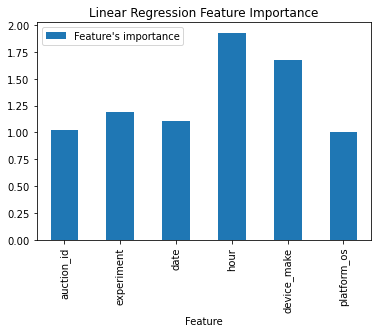

In [41]:
mlm.evaluate_model(model, cm_data, chrome_set[2], chrome_set[3], "Linear Regression", globals())

The model accuracy is:  0.5652173913043478


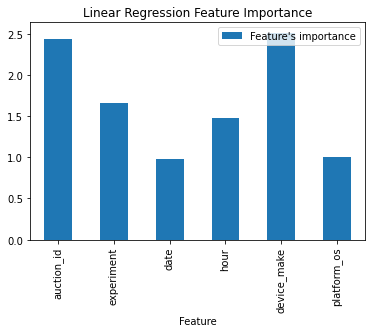

In [42]:
mlm.evaluate_model(model2, cm_w_data, chrome_mobile_set[2], chrome_mobile_set[3], "Linear Regression", globals())

The model accuracy is:  0.6875


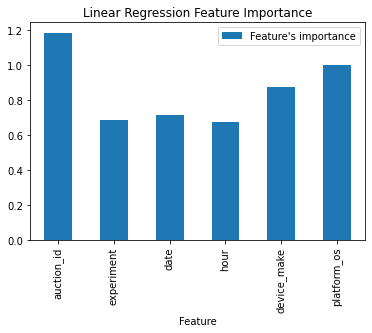

In [43]:
mlm.evaluate_model(model3, fb_data, facebook_set[2], facebook_set[3], "Linear Regression", globals())

The model accuracy is:  0.6016260162601627


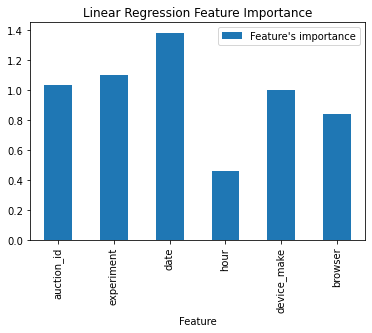

In [44]:
mlm.evaluate_model(model4, pl_5_data, platform_5_set[2], platform_5_set[3], "Linear Regression", globals())

The model accuracy is:  1.0


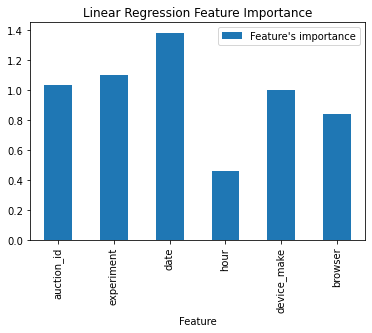

In [45]:
mlm.evaluate_model(model5, pl_6_data, platform_6_set[2], platform_6_set[3], "Linear Regression", globals())

In [46]:
# Finding the intercept of our regression model

model.intercept_

array([-0.68878456])

In [47]:
# Creating a features dataframe to see the importance

features_browser = ['auction_id','experiment','date','hour','device_make','platform_os']
features_platform = ['auction_id','experiment','date','hour','device_make','browser']
feature_importance_cm_df = pd.DataFrame(features_browser,columns=['Feature'])

In [48]:
# Creating a new column for the feature importance

feature_importance_cm_df['Feature\'s importance'] = pow(math.e,np.array(model.coef_[0]))
feature_importance_cm_df.head(10)

,Feature,Feature's importance
0,auction_id,1.024659
1,experiment,1.188303
2,date,1.103739
3,hour,1.929474
4,device_make,1.673883
5,platform_os,1.000000


In [49]:
feature_importance_cm_df['Feature\'s importance'] = pow(math.e,np.array(model2.coef_[0]))
feature_importance_cm_df.head(10)

,Feature,Feature's importance
0,auction_id,2.440862
1,experiment,1.656604
2,date,0.975934
3,hour,1.480304
4,device_make,2.513241
5,platform_os,1.000000


In [50]:
feature_importance_cm_df['Feature\'s importance'] = pow(math.e,np.array(model3.coef_[0]))
feature_importance_cm_df.head(10)

,Feature,Feature's importance
0,auction_id,1.185379
1,experiment,0.684069
2,date,0.711869
3,hour,0.673289
4,device_make,0.875656
5,platform_os,1.000000


In [51]:
feature_importance_cm_df['Feature\'s importance'] = pow(math.e,np.array(model4.coef_[0]))
feature_importance_cm_df.head(10)

,Feature,Feature's importance
0,auction_id,1.034687
1,experiment,1.099414
2,date,1.385556
3,hour,0.458619
4,device_make,1.000000
5,platform_os,0.839248


In [52]:
feature_importance_cm_df['Feature\'s importance'] = pow(math.e,np.array(model5.coef_[0]))
feature_importance_cm_df.head(10)

,Feature,Feature's importance
0,auction_id,1.034687
1,experiment,1.099414
2,date,1.385556
3,hour,0.458619
4,device_make,1.000000
5,platform_os,0.839248
